## 0. Importing Hannes Functions

In [1]:
import pandas as pd
import numpy as np
import csv

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer 
from nltk.stem import PorterStemmer
#nltk.download('stopwords')
from nltk.corpus import stopwords

#!python -m spacy download en_core_web_sm
import spacy
sp = spacy.load('en_core_web_sm')

import re


from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import os

import re



from tqdm import tqdm
tqdm.pandas()


#getting a library of stopwords and defining a lemmatizer
porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

In [3]:
#additional functions

def strip(word):
    mod_string = re.sub(r'\W+', '', word)
    return mod_string

#the following leaves in place two or more capital letters in a row
#will be ignored when using standard stemming
def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

#modular pipeline for stemming, lemmatizing and lowercasing
#note this is NOT lemmatizing using grammar pos
    
def tokenize(text, modulation):
    if modulation<2:
        tokens = re.split(r'\W+', text)
        stems = []
        # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
        for token in tokens:
            lowers=abbr_or_lower(token)
            if lowers not in stop_words:
                if re.search('[a-zA-Z]', lowers):
                    if modulation==0:
                        stems.append(lowers)
                    if modulation==1:
                        stems.append(porter.stem(lowers))
    else:
        sp_text=sp(text)
        stems = []
        lemmatized_text=[]
        for word in sp_text:
            lemmatized_text.append(word.lemma_)
        stems = [abbr_or_lower(strip(w)) for w in lemmatized_text if (abbr_or_lower(strip(w))) and (abbr_or_lower(strip(w)) not in stop_words)]
    return " ".join(stems)

## 1. Session 8 code - This will do pre-preprocessing with td-idf and SVD. I will try with European Commission today.

In [6]:
#loading the data

path="/Users/ruimaciel/Desktop/Barcelona/NLP_I/NLP-Project/"
filename ="data/thewhitehouse_preprocessed_p1.csv"
WH_data_1 = pd.read_csv(os.path.join(path, filename), sep=',', encoding='utf-8')
filename ="data/thewhitehouse_preprocessed_p2.csv"
WH_data_2 = pd.read_csv(os.path.join(path, filename), sep=',', encoding='utf-8')
# Concatenate the two DataFrames
WH_data = pd.concat([WH_data_1, WH_data_2], ignore_index=True)

# Display the concatenated DataFrame
WH_data.head()



,Title,Date,Category,Text,text_preproc,titles_preproc,Ukraine
0,Fact Sheet: President-elect Biden Outlines COV...,2021-01-15,Statement,Effectively and equitably vaccinating the U.S....,effectively equitably vaccinate US population ...,fact sheet president elect biden outlines covi...,0
1,Fact Sheet: List of Agency Actions for Review,2021-01-20,Statement,"Actions Address the COVID-19 Pandemic, Provide...",actions address covid19 pandemic provide econo...,fact sheet list agency actions review,0
2,Fact Sheet: President Biden Sends Immigration ...,2021-01-20,Statement,The U.S. Citizenship Act of 2021 establishes a...,US citizenship act 2021 establish new system r...,fact sheet president biden sends immigration b...,0
3,"A Letter to Dr. Eric S. Lander, the President’...",2021-01-20,Statement,"On January 15, 2021, then-President-Elect Bide...",january 15 2021 president elect biden send fol...,letter dr eric lander president science adviso...,0
4,Paris Climate Agreement,2021-01-20,Statement,ACCEPTANCE ON BEHALF OF THE UNITED STATES OF A...,acceptance ON BEHALF UNITED STATES AMERICA jos...,paris climate agreement,0


In [25]:
#all hail the implementation of CV in sci-kit learn
cv = CountVectorizer(ngram_range = (1,2), lowercase=True, min_df=0.001, max_df=0.4, stop_words='english')
#cv = CountVectorizer(ngram_range = (1,2), lowercase=True, min_df=10, max_df=0.4, stop_words='english')
#cv = TfidfVectorizer(ngram_range = (1,2), norm=None, lowercase=True, min_df=10, max_df=0.4, stop_words='english')
cv.fit(WH_data.Text)


vectorized_text=cv.transform(WH_data.Text)
vectorized_text=vectorized_text.toarray()
print("document term matrix has size", vectorized_text.shape)

document term matrix has size (7846, 116507)


In [26]:
vectorized_title=cv.transform(WH_data.Text)
vectorized_title=vectorized_title.toarray()
print("document term matrix has size", vectorized_title.shape)

document term matrix has size (7846, 116507)


In [27]:
dtm=4*vectorized_title+vectorized_text

In [28]:
from sklearn.decomposition import TruncatedSVD

# Apply SVD, we choose n_components = 2 for simplicity
svd = TruncatedSVD(n_components=10)
U = svd.fit_transform(dtm)
Sigma = svd.singular_values_
VT = svd.components_

print("U (document-topic matrix):\n", U)
print("\nSigma (singular values):\n", Sigma)
print("\nVT (topic-term matrix):\n", VT)


U (document-topic matrix):
 [[ 58.43149976  44.07954054 125.01341131 ...  15.91267734  -8.23216215
  -14.34682835]
 [ 45.8795353   22.7790259   91.27109988 ... -10.49892409 -28.62249231
   19.86050859]
 [ 34.41951971  18.77792907  62.68257116 ...   4.61605171   1.02781198
  -25.31814694]
 ...
 [ 29.09785206  22.24483965  70.97351397 ...  -1.94657793 -15.13001778
   -4.34887843]
 [  7.84806039   1.67432469  12.87547081 ...   0.75076979   1.01124304
    2.09913614]
 [  7.28017466   1.35594989   8.45790081 ...  -0.5436893    2.48257473
    3.46738682]]

Sigma (singular values):
 [20550.15689992  9943.97696252  8105.23469868  6191.76328812
  4893.09367477  4736.69097508  4135.47728336  4032.23922196
  3759.48248535  3641.25670566]

VT (topic-term matrix):
 [[ 2.00997769e-03  1.86602235e-05  3.24567074e-04 ...  3.81545196e-05
   9.91473204e-05  1.33796022e-05]
 [ 5.32281264e-04  4.17491973e-05  1.61404300e-04 ...  4.76300856e-06
   3.41165365e-05  3.40384954e-05]
 [ 4.67171365e-03  8.628732

In [34]:
terms = cv.get_feature_names_out()
for i, comp in enumerate(VT):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:5]
    print("Topic " + str(i+1) + ": ", sorted_terms)

Topic 1:  [('ms', 0.3470582649685979), ('going', 0.30806648525531455), ('know', 0.2830891081942922), ('jean', 0.17131531140276174), ('pierre', 0.17124258993889568)]
Topic 2:  [('psaki', 0.4503785835737128), ('ms psaki', 0.4502643207544755), ('ms', 0.1381635717717089), ('jen', 0.06972399078716014), ('health', 0.05867056588592125)]
Topic 3:  [('health', 0.2014228934757636), ('applause', 0.13332157626428767), ('million', 0.13014610885160124), ('communities', 0.1277300290919761), ('care', 0.12352982535078845)]
Topic 4:  [('ms', 0.2367660043101396), ('pierre', 0.1794414884438325), ('jean', 0.1793486780715019), ('jean pierre', 0.17933828242887853), ('ms jean', 0.17930479056373352)]
Topic 5:  [('applause', 0.2861208234268356), ('jobs', 0.13452958810432666), ('23', 0.12757012202705476), ('act', 0.11339051486479142), ('inflation', 0.11009081831945608)]
Topic 6:  [('climate', 0.19492068342550156), ('energy', 0.19388450681034822), ('ukraine', 0.16107220337376146), ('senior', 0.138322770441539), (

In [35]:
#exploring artricles/topic loadings in this representation
print(U.shape)
second_row_of_U = U[1, :]
print("Second row of U:", second_row_of_U)


#remember article two was very much topic 1 - let's check the article
WH_data.text_preproc[1]

(7846, 10)
Second row of U: [ 45.8795353   22.7790259   91.27109988  70.20093014  -4.39158303
  25.55768541  -2.66389217 -10.49892409 -28.62249231  19.86050859]


'actions address covid19 pandemic provide economic relief tackle climate change advance racial equity non exclusive list agency action head relevant agency review accordance executive order protect public health environment restore science tackle climate crisis additional agency action also review determine consistency section 1 executive order note action publish january 20 federal register add list COUNCIL ON ENVIRONMENTAL QUALITY guidance document procedure 86 fed reg 1279 january 8 2021 update regulations implement procedural provisions national environmental policy act 85 fed reg 43304 july 16 2020 US DEPARTMENT AGRICULTURE special areas roadless area conservation national forest system lands alaska 85 fed reg 68688 october 29 2020 US DEPARTMENT COMMERCE take importing marine mammals take marine mammals incidental geophysical surveys relate oil gas activity gulf mexico 86 fed reg 5322 january 19 2021 endangered threatened wildlife plants regulation listing endangered threatened sp

In [36]:
# Assuming Sigma contains the singular values from an SVD operation
total_variance = sum(Sigma**2)
variance_explained = [(i**2) / total_variance for i in Sigma]
cumulative_variance_explained = np.cumsum(variance_explained)

# Printing variance explained by each component
for i, variance in enumerate(variance_explained):
    print(f"Component {i+1}: Variance explained: {variance*100:.2f}%")

# Printing cumulative variance explained
print("\nCumulative variance explained by components:")
for i, cumulative_variance in enumerate(cumulative_variance_explained):
    print(f"Components 1 to {i+1}: Cumulative variance explained: {cumulative_variance*100:.2f}%")

Component 1: Variance explained: 57.66%
Component 2: Variance explained: 13.50%
Component 3: Variance explained: 8.97%
Component 4: Variance explained: 5.23%
Component 5: Variance explained: 3.27%
Component 6: Variance explained: 3.06%
Component 7: Variance explained: 2.34%
Component 8: Variance explained: 2.22%
Component 9: Variance explained: 1.93%
Component 10: Variance explained: 1.81%

Cumulative variance explained by components:
Components 1 to 1: Cumulative variance explained: 57.66%
Components 1 to 2: Cumulative variance explained: 71.17%
Components 1 to 3: Cumulative variance explained: 80.14%
Components 1 to 4: Cumulative variance explained: 85.37%
Components 1 to 5: Cumulative variance explained: 88.64%
Components 1 to 6: Cumulative variance explained: 91.70%
Components 1 to 7: Cumulative variance explained: 94.04%
Components 1 to 8: Cumulative variance explained: 96.26%
Components 1 to 9: Cumulative variance explained: 98.19%
Components 1 to 10: Cumulative variance explaine

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer with your desired parameters
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), lowercase=True, min_df=0.02, max_df=0.6, stop_words='english')

# Fit and transform your text data using TF-IDF vectorizer
tfidf_matrix_text = tfidf_vectorizer.fit_transform(WH_data.Text)
tfidf_matrix_title = tfidf_vectorizer.transform(WH_data.Text)

# If you want to combine title and text information, do so here

# Perform Singular Value Decomposition (SVD) on TF-IDF matrices
svd = TruncatedSVD(n_components=10)
U_text = svd.fit_transform(tfidf_matrix_text)
U_title = svd.transform(tfidf_matrix_title)

# Now you can observe the resulting topics extracted from both text and title information


In [38]:
# Print the top words associated with each topic for Count Vectorization
print("Top words associated with each topic (Count Vectorization):")
feature_names_count = cv.get_feature_names_out()
for topic_idx, topic in enumerate(VT):
    top_words_idx = topic.argsort()[::-1][:10]  # Get indices of top 10 words
    top_words = [feature_names_count[i] for i in top_words_idx]
    print(f"Topic {topic_idx+1}: {', '.join(top_words)}")

# Print the top words associated with each topic for TF-IDF Vectorization
print("\nTop words associated with each topic (TF-IDF Vectorization):")
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(svd.components_):
    top_words_idx = topic.argsort()[::-1][:10]  # Get indices of top 10 words
    top_words = [feature_names_tfidf[i] for i in top_words_idx]
    print(f"Topic {topic_idx+1}: {', '.join(top_words)}")


Top words associated with each topic (Count Vectorization):
Topic 1: ms, going, know, jean, pierre, jean pierre, ms jean, ve, psaki, ms psaki
Topic 2: psaki, ms psaki, ms, jen, health, course, point, range, certainly, steps
Topic 3: health, applause, million, communities, care, energy, climate, law, billion, access
Topic 4: ms, pierre, jean, jean pierre, ms jean, health, department, communities, energy, care
Topic 5: applause, jobs, 23, act, inflation, tweet, law, costs, families, going
Topic 6: climate, energy, ukraine, senior, senior administration, russia, countries, official, administration official, mr
Topic 7: 23, energy, climate, inflation, tweet, reduction, costs, inflation reduction, reduction act, clean
Topic 8: mr, kirby, mr kirby, care, ukraine, health, 23, tweet, israel, military
Topic 9: senior, senior administration, official, administration official, 23, care, tweet, health, statement, families
Topic 10: law, dr, university, 23, climate, served, member, vice, energy, re

## 2. Session 9 code - This will apply LDA 

In [39]:
#now we will not touch the text with the CV as we have pre-processed already
cv = CountVectorizer(ngram_range = (1,2), lowercase=False, min_df=0.001, max_df=0.4)
#cv = CountVectorizer(ngram_range = (1,2), lowercase=True, min_df=10, max_df=0.4, stop_words='english')
#cv = TfidfVectorizer(ngram_range = (1,2), norm=None, lowercase=True, min_df=10, max_df=0.4, stop_words='english')
cv.fit(WH_data.text_preproc)

vectorized_text=cv.transform(WH_data.text_preproc)
vectorized_text=vectorized_text.toarray()
print("document term matrix has size", vectorized_text.shape)

vectorized_title=cv.transform(WH_data.titles_preproc)
vectorized_title=vectorized_title.toarray()
print("document term matrix for titles has size", vectorized_title.shape)

dtm=4*vectorized_title+vectorized_text

document term matrix has size (7846, 133096)
document term matrix for titles has size (7846, 133096)


In [40]:
from gensim import corpora, models
from gensim.matutils import Sparse2Corpus
from scipy.sparse import csr_matrix


In [41]:
#gensim needs the dtm in a different sparce format
dtm_sparse = csr_matrix(dtm)

# Convert sparse matrix to gensim corpus
corpus = Sparse2Corpus(dtm_sparse, documents_columns=False)

# Create gensim dictionary from sklearn CountVectorizer vocabulary
vocabulary_gensim = {}
for key, val in cv.vocabulary_.items():
    vocabulary_gensim[val] = key

dictionary = corpora.Dictionary()
dictionary.id2token = vocabulary_gensim
dictionary.token2id = cv.vocabulary_

In [42]:
# Number of topics
num_topics = 15

# Build LDA model
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20, random_state=42)

# Display the topics
topics = lda_model.print_topics(num_words=30)
for topic in topics:
    print(topic)
    print("    ")

(0, '0.010*"say" + 0.007*"applause" + 0.007*"think" + 0.005*"job" + 0.005*"thing" + 0.005*"look" + 0.005*"want" + 0.004*"pay" + 0.004*"lot" + 0.004*"mean" + 0.004*"PRESIDENT" + 0.004*"folk" + 0.004*"talk" + 0.003*"back" + 0.003*"every" + 0.003*"laughter" + 0.003*"percent" + 0.003*"see" + 0.003*"much" + 0.003*"big" + 0.003*"let" + 0.003*"remark president" + 0.003*"economy" + 0.003*"would" + 0.002*"really" + 0.002*"remark" + 0.002*"happen" + 0.002*"able" + 0.002*"billion" + 0.002*"cost"')
    
(1, '0.013*"climate" + 0.009*"global" + 0.008*"energy" + 0.008*"technology" + 0.006*"sector" + 0.006*"development" + 0.006*"investment" + 0.005*"partnership" + 0.005*"initiative" + 0.004*"supply" + 0.004*"international" + 0.004*"private" + 0.004*"partner" + 0.004*"chain" + 0.004*"develop" + 0.004*"clean" + 0.004*"supply chain" + 0.004*"action" + 0.004*"infrastructure" + 0.003*"critical" + 0.003*"strengthen" + 0.003*"advance" + 0.003*"resilience" + 0.003*"address" + 0.003*"summit" + 0.003*"change" +

In [43]:
# Using get_document_topics with an explicit minimum_probability
doc_topics = [lda_model.get_document_topics(item, minimum_probability=0.0000001) for item in corpus]

#note you could also use this vector = [lda[item] for item in corpus] but this has a higher threshold. 
#I like my topic vectors complete!

#this produces a lits of tuples
print(doc_topics[0])

#Scroll back to the top and inspect the first article. This checks out!

[(0, 4.601901e-05), (1, 0.017537717), (2, 4.601893e-05), (3, 4.6018995e-05), (4, 0.29546577), (5, 4.6018955e-05), (6, 4.6018948e-05), (7, 0.5670495), (8, 4.601901e-05), (9, 0.09243584), (10, 4.601899e-05), (11, 0.02705103), (12, 4.601897e-05), (13, 4.601899e-05), (14, 4.6018966e-05)]


In [ ]:
#I ignored word cloud.

In [44]:
# Assuming corpus_data is your existing DataFrame
# Ensure it has the same number of rows as the length of doc_topics

# Initialize the columns for each topic with default value 0
for topic_num in range(15):
    WH_data[f'topic_{topic_num}'] = 0.0

# Iterate over the document topics to fill the DataFrame
for i, doc_distribution in enumerate(doc_topics):
    for topic_num, prob in doc_distribution:
        WH_data.at[i, f'topic_{topic_num}'] = prob

WH_data

,Title,Date,Category,Text,text_preproc,titles_preproc,Ukraine,topic_0,topic_1,topic_2,...,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,Fact Sheet: President-elect Biden Outlines COV...,2021-01-15,Statement,Effectively and equitably vaccinating the U.S....,effectively equitably vaccinate US population ...,fact sheet president elect biden outlines covi...,0,0.000046,0.017538,0.000046,...,0.000046,0.000046,0.567050,0.000046,0.092436,0.000046,0.027051,0.000046,0.000046,0.000046
1,Fact Sheet: List of Agency Actions for Review,2021-01-20,Statement,"Actions Address the COVID-19 Pandemic, Provide...",actions address covid19 pandemic provide econo...,fact sheet list agency actions review,0,0.000036,0.088882,0.382731,...,0.000036,0.000036,0.000036,0.000036,0.426940,0.000036,0.000036,0.000036,0.022848,0.000036
2,Fact Sheet: President Biden Sends Immigration ...,2021-01-20,Statement,The U.S. Citizenship Act of 2021 establishes a...,US citizenship act 2021 establish new system r...,fact sheet president biden sends immigration b...,0,0.000051,0.058659,0.000051,...,0.000051,0.000051,0.000051,0.038624,0.158925,0.031440,0.000051,0.000051,0.020308,0.000051
3,"A Letter to Dr. Eric S. Lander, the President’...",2021-01-20,Statement,"On January 15, 2021, then-President-Elect Bide...",january 15 2021 president elect biden send fol...,letter dr eric lander president science adviso...,0,0.000063,0.408380,0.013922,...,0.011880,0.000063,0.001422,0.000063,0.165499,0.118033,0.104433,0.000063,0.131987,0.004174
4,Paris Climate Agreement,2021-01-20,Statement,ACCEPTANCE ON BEHALF OF THE UNITED STATES OF A...,acceptance ON BEHALF UNITED STATES AMERICA jos...,paris climate agreement,0,0.001022,0.337149,0.302955,...,0.058812,0.001022,0.001022,0.001022,0.001022,0.115107,0.001022,0.001022,0.001022,0.001022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7841,Readout of National Security Advisor Jake Sull...,2023-12-29,Statement,National Security Advisor Jake Sullivan spoke ...,national security advisor jake sullivan speak ...,readout national security advisor jake sulliva...,0,0.000491,0.000491,0.000491,...,0.135250,0.000491,0.000491,0.000491,0.000491,0.000491,0.000491,0.000491,0.000491,0.751589
7842,Statement from President Joe Biden on Russia’s...,2023-12-29,Statement,"Overnight, Russia launched its largest aerial ...",overnight russia launch large aerial assault u...,statement president joe biden russia aerial as...,1,0.000272,0.013828,0.000272,...,0.336673,0.265617,0.000272,0.000272,0.000272,0.380895,0.000272,0.000272,0.000272,0.000272
7843,FACT SHEET: Biden-⁠Harris Administration Relea...,2023-12-30,Statement,The Biden-Harris Administration continues to p...,biden harris administration continue prioritiz...,fact sheet BidenHarris administration releases...,1,0.000075,0.491396,0.010007,...,0.000075,0.000075,0.025474,0.000075,0.000075,0.000075,0.000075,0.000075,0.006103,0.000075
7844,Statement from President Joe Biden on the Pass...,2023-12-31,Statement,"Eddie Bernice Johnson was a dedicated nurse, s...",eddie bernice johnson dedicated nurse state le...,statement president joe biden passing former c...,0,0.000296,0.000296,0.000296,...,0.000296,0.000296,0.000296,0.000296,0.197854,0.719574,0.000296,0.000296,0.079015,0.000296


In [45]:
#Check this for whether topic shares correctly specified - should add to 1.

# Step 1: Calculate the sum of topic shares for each document
WH_data['topic_sum'] = WH_data[[f'topic_{i}' for i in range(15)]].sum(axis=1)

# Step 2: Create a test column that checks if the sum is close to 1
# We use numpy's isclose function to allow for a small margin of error in floating-point comparisons
import numpy as np
WH_data['sum_is_1'] = np.isclose(WH_data['topic_sum'], 1.0)

# Step 3: Produce summary statistics
# This gives you the count of True and False values in the 'sum_is_1' column
summary_stats = WH_data['sum_is_1'].value_counts()

print(summary_stats)

sum_is_1
True    7846
Name: count, dtype: int64


In [46]:
alpha_prior = lda_model.alpha
total_alpha_prior = sum(alpha_prior)  # This is useful for later calculations
print("Alpha prior:", alpha_prior)
print("Total alpha prior:", total_alpha_prior)

Alpha prior: [0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667]
Total alpha prior: 1.0000000521540642


In [47]:
# I needed to add a column with the number of words in the article.

WH_data['length_in_words'] = WH_data['text_preproc'].apply(lambda x: len(x.split()))


In [48]:
# For each topic column, calculate the words attributed to that topic
for i in range(15):
    WH_data[f'words_topic_{i}'] = WH_data[f'topic_{i}'] * WH_data['length_in_words']

In [49]:
WH_data['year_month'] = pd.to_datetime(WH_data['Date']).dt.strftime('%Y-%m')
print(WH_data.dtypes)


Title               object
Date                object
Category            object
Text                object
text_preproc        object
titles_preproc      object
Ukraine              int64
topic_0            float64
topic_1            float64
topic_2            float64
topic_3            float64
topic_4            float64
topic_5            float64
topic_6            float64
topic_7            float64
topic_8            float64
topic_9            float64
topic_10           float64
topic_11           float64
topic_12           float64
topic_13           float64
topic_14           float64
topic_sum          float64
sum_is_1              bool
length_in_words      int64
words_topic_0      float64
words_topic_1      float64
words_topic_2      float64
words_topic_3      float64
words_topic_4      float64
words_topic_5      float64
words_topic_6      float64
words_topic_7      float64
words_topic_8      float64
words_topic_9      float64
words_topic_10     float64
words_topic_11     float64
w

In [50]:
# Prepare the data for aggregation
aggregation_data = WH_data[['year_month'] + [f'words_topic_{i}' for i in range(15)]]

# Group by year and month, and sum the word counts for topics
grouped_data = aggregation_data.groupby(['year_month']).sum().reset_index()

# Now adjust these sums by adding alpha_prior to each topic's word count
# and divide by the total words in each group plus total_alpha_prior
for i in range(15):
    grouped_data[f'topic_share_{i}'] = (grouped_data[f'words_topic_{i}'] + alpha_prior[i]) / (grouped_data[[f'words_topic_{j}' for j in range(15)]].sum(axis=1) + total_alpha_prior)

# Select only the year, month, and topic share columns for the final DataFrame
final_columns = ['year_month'] + [f'topic_share_{i}' for i in range(15)]
result_df = grouped_data[final_columns]





In [51]:
result_df.head()

,year_month,topic_share_0,topic_share_1,topic_share_2,topic_share_3,topic_share_4,topic_share_5,topic_share_6,topic_share_7,topic_share_8,topic_share_9,topic_share_10,topic_share_11,topic_share_12,topic_share_13,topic_share_14
0,2021-01,0.078216,0.054469,0.019474,0.015067,0.122689,0.014165,0.007751,0.033164,0.305593,0.094458,0.057378,0.081714,0.087133,0.013512,0.015220
1,2021-02,0.091272,0.025246,0.013601,0.023270,0.062612,0.036484,0.006604,0.089986,0.326035,0.032572,0.058351,0.133012,0.065433,0.019755,0.015767
2,2021-03,0.092263,0.017569,0.007792,0.023122,0.057638,0.024130,0.015326,0.098275,0.279407,0.068032,0.080020,0.118853,0.065478,0.038204,0.013890
3,2021-04,0.077287,0.048344,0.016305,0.021070,0.040213,0.028883,0.029601,0.076285,0.227939,0.130297,0.060821,0.081708,0.052029,0.098796,0.010420
4,2021-05,0.120558,0.043628,0.009811,0.031462,0.054429,0.048562,0.017274,0.081865,0.241686,0.079084,0.076807,0.078166,0.077175,0.025903,0.013591


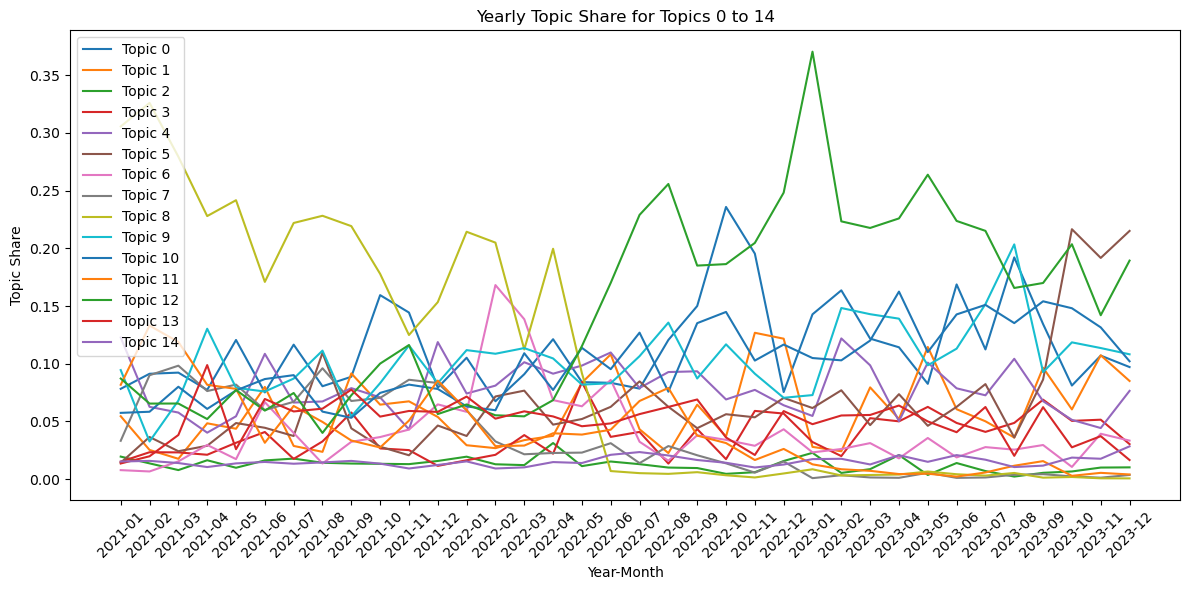

In [52]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(12, 6))

# Plot each topic share over time within the filtered range
for i in range(15):  # Assuming topic_share columns are named from 'topic_share_0' to 'topic_share_14'
    plt.plot(result_df['year_month'], result_df[f'topic_share_{i}'], label=f'Topic {i}')

# Rotate the x-axis tick labels for better readability
plt.xticks(rotation=45)

# Adding labels and title
plt.xlabel('Year-Month')
plt.ylabel('Topic Share')
plt.title('Yearly Topic Share for Topics 0 to 14')

plt.legend()

# Show plot
plt.tight_layout()
plt.show()

## 2. Here will be the TA_session

In [53]:
import pandas as pd
import numpy as np
import csv

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer 
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

import re
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import os
import re
from tqdm import tqdm
tqdm.pandas()
#getting a library of stopwords and defining a lemmatizer
porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

In [54]:
#loading the data

path="/Users/ruimaciel/Desktop/Barcelona/NLP_I/NLP-Project/"
filename ="data/thewhitehouse_preprocessed_p1.csv"
WH_data_1 = pd.read_csv(os.path.join(path, filename), sep=',', encoding='utf-8')
filename ="data/thewhitehouse_preprocessed_p2.csv"
WH_data_2 = pd.read_csv(os.path.join(path, filename), sep=',', encoding='utf-8')
# Concatenate the two DataFrames
WH_data = pd.concat([WH_data_1, WH_data_2], ignore_index=True)

# Display the concatenated DataFrame
WH_data.head()

,Title,Date,Category,Text,text_preproc,titles_preproc,Ukraine
0,Fact Sheet: President-elect Biden Outlines COV...,2021-01-15,Statement,Effectively and equitably vaccinating the U.S....,effectively equitably vaccinate US population ...,fact sheet president elect biden outlines covi...,0
1,Fact Sheet: List of Agency Actions for Review,2021-01-20,Statement,"Actions Address the COVID-19 Pandemic, Provide...",actions address covid19 pandemic provide econo...,fact sheet list agency actions review,0
2,Fact Sheet: President Biden Sends Immigration ...,2021-01-20,Statement,The U.S. Citizenship Act of 2021 establishes a...,US citizenship act 2021 establish new system r...,fact sheet president biden sends immigration b...,0
3,"A Letter to Dr. Eric S. Lander, the President’...",2021-01-20,Statement,"On January 15, 2021, then-President-Elect Bide...",january 15 2021 president elect biden send fol...,letter dr eric lander president science adviso...,0
4,Paris Climate Agreement,2021-01-20,Statement,ACCEPTANCE ON BEHALF OF THE UNITED STATES OF A...,acceptance ON BEHALF UNITED STATES AMERICA jos...,paris climate agreement,0


In [67]:
#I will not lemmatize as I will did it previously

In [55]:
#all hail the implementation of CV in sci-kit learn
cv = CountVectorizer(ngram_range = (1,2), lowercase=True, min_df=0.001, max_df=0.4, stop_words='english')
# we get bigrams and unigrams, we ignore words that appear in less than 0.1% of the documents and more than 40% of the documents

cv.fit(WH_data.text_preproc)

vectorized_text=cv.transform(WH_data.text_preproc)
vectorized_text=vectorized_text.toarray()
print("document term matrix has size", vectorized_text.shape)

document term matrix has size (7846, 119037)


In [56]:
#gensim needs the dtm in a different sparce format
dtm_sparse = csr_matrix(dtm)

# Convert sparse matrix to gensim corpus
corpus = Sparse2Corpus(dtm_sparse, documents_columns=False)

# Create gensim dictionary from sklearn CountVectorizer vocabulary
vocabulary_gensim = {}
for key, val in cv.vocabulary_.items():
    vocabulary_gensim[val] = key

dictionary = corpora.Dictionary()
dictionary.id2token = vocabulary_gensim
dictionary.token2id = cv.vocabulary_

In [57]:
# ILLUSTRATION: 
cv2 = CountVectorizer(ngram_range = (1,2), lowercase=True, stop_words='english')
# we get bigrams and unigrams, we ignore words that appear in less than 0.1% of the documents and more than 40% of the documents

cv2.fit(WH_data.text_preproc[0:1])
vocabulary = cv2.get_feature_names_out()

print(WH_data.text_preproc[0])  # Access the first element of 'Text' column using iloc[0]
print('\n\n')
print(vocabulary)


effectively equitably vaccinate US population happen strong partnership state community increase supply vaccination site vaccinator covid19 pandemic get bad day people hospitalize COVID19 ever death rate almost 20 percent near 400000 death total time new contagious strain spread across country woefully behind vaccinate US population president elect biden confront historic challenge full strength federal government work closely local community already trench lead unprecedented whole society effort mobilize every resource available across public private sector take every american part move forward get vaccine arm quickly possible leave anyone behind community across country count health economic security nation depend today president elect outline key highlight plan efficiently equitably vaccinate US population include take action get people vaccinate encourage state allow people vaccinate include individual 65 old well frontline worker process establish priority group drive science impl

In [58]:
print(WH_data.text_preproc[0])  # Access the first element of 'Text' column using iloc[0]


effectively equitably vaccinate US population happen strong partnership state community increase supply vaccination site vaccinator covid19 pandemic get bad day people hospitalize COVID19 ever death rate almost 20 percent near 400000 death total time new contagious strain spread across country woefully behind vaccinate US population president elect biden confront historic challenge full strength federal government work closely local community already trench lead unprecedented whole society effort mobilize every resource available across public private sector take every american part move forward get vaccine arm quickly possible leave anyone behind community across country count health economic security nation depend today president elect outline key highlight plan efficiently equitably vaccinate US population include take action get people vaccinate encourage state allow people vaccinate include individual 65 old well frontline worker process establish priority group drive science impl

In [60]:
vectorized_title=cv.transform(WH_data.text_preproc) # this uses the same vocabulary as the text
vectorized_title=vectorized_title.toarray()
print("document term matrix has size", vectorized_title.shape)
dtm=4*vectorized_title+vectorized_text # we give more weight to the title
print(type(dtm))

document term matrix has size (7846, 119037)
<class 'numpy.ndarray'>


In [61]:
from gensim import corpora, models
from gensim.matutils import Sparse2Corpus
from scipy.sparse import csr_matrix

#gensim needs the dtm in a different sparce format (from numpy to csr_matrix)
dtm_sparse = csr_matrix(dtm)

# Convert sparse matrix to gensim corpus
corpus = Sparse2Corpus(dtm_sparse, documents_columns=False)

# Create gensim dictionary from sklearn CountVectorizer vocabulary
vocabulary_gensim = {}
for key, val in cv.vocabulary_.items(): # remember cv has been fitted to the data
    vocabulary_gensim[val] = key

dictionary = corpora.Dictionary()
dictionary.id2token = vocabulary_gensim
dictionary.token2id = cv.vocabulary_


In [62]:
# Number of topics
num_topics = 10

# Build LDA model
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20, random_state=42)

# Display the topics
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.009*"vice president" + 0.009*"vice" + 0.006*"woman" + 0.006*"applause" + 0.005*"fight" + 0.005*"life" + 0.004*"stand" + 0.004*"say" + 0.004*"great" + 0.003*"freedom"')
(1, '0.009*"ukraine" + 0.008*"think" + 0.007*"russia" + 0.007*"official" + 0.006*"senior" + 0.005*"say" + 0.005*"administration official" + 0.005*"question" + 0.005*"senior administration" + 0.004*"mr"')
(2, '0.013*"say" + 0.012*"applause" + 0.009*"think" + 0.006*"want" + 0.006*"thing" + 0.006*"look" + 0.005*"mean" + 0.005*"lot" + 0.005*"talk" + 0.004*"folk"')
(3, '0.008*"climate" + 0.006*"energy" + 0.005*"global" + 0.005*"technology" + 0.004*"investment" + 0.004*"development" + 0.004*"partnership" + 0.004*"clean" + 0.003*"strengthen" + 0.003*"cooperation"')
(4, '0.012*"federal" + 0.008*"district" + 0.008*"infrastructure" + 0.007*"water" + 0.006*"tribal" + 0.006*"law" + 0.005*"funding" + 0.005*"term" + 0.005*"fema" + 0.005*"judge"')
(5, '0.011*"job" + 0.009*"cost" + 0.009*"economy" + 0.008*"price" + 0.008*"pay" + 

In [63]:
#The goal here is to compare the SVD with the LDA.

from sklearn.decomposition import TruncatedSVD

# Apply SVD, we choose n_components = 2 for simplicity
svd = TruncatedSVD(n_components=10)
U = svd.fit_transform(dtm)
Sigma = svd.singular_values_
VT = svd.components_


terms = cv.get_feature_names_out()
for i, comp in enumerate(VT):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:5]
    print("Topic " + str(i+1) + ": ", sorted_terms)

Topic 1:  [('ms', 0.37866418207941144), ('say', 0.31321161988248725), ('psaki', 0.18782705036432826), ('ms psaki', 0.1875514104671052), ('jean', 0.17813245502875114)]
Topic 2:  [('jean pierre', 0.3432643390244389), ('jean', 0.34324128302028495), ('pierre', 0.34322309845106674), ('ms jean', 0.3431360954671837), ('kirby', 0.0886895542521969)]
Topic 3:  [('health', 0.19731910584245677), ('program', 0.13977293506658997), ('care', 0.1254095325398974), ('investment', 0.12261384048224382), ('energy', 0.11824319645802031)]
Topic 4:  [('applause', 0.2811139217757938), ('think', 0.27048018167437293), ('say', 0.24163546619134263), ('mr', 0.1742461853616437), ('thing', 0.1464449333135143)]
Topic 5:  [('applause', 0.26800847949154294), ('job', 0.14444557921885529), ('pay', 0.1311096610242579), ('cost', 0.12221890154687022), ('inflation', 0.10420266461568381)]
Topic 6:  [('ukraine', 0.1660439344641452), ('official', 0.16548403016104532), ('administration official', 0.15788025924095891), ('climate', 

In [64]:

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis


vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

pyLDAvis.display(vis_data)


In [80]:
#This is to do coherence. It is purely mathematical so it may not be good.

from gensim.models.coherencemodel import CoherenceModel

cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()  # get coherence value
coherence

-0.7000061640486692

In [43]:
#This took ages to run. As it is quite irrelevant, I would not run it again.


def compute_coherence(num_topics, corpus, dictionary):
    lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20, random_state=42)
    coherence_model = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
    coherence = coherence_model.get_coherence()
    return coherence

coherence_values = []


min_topics = 2
max_topics = 10
step_size = 1

# Iterate over different numbers of topics
for num_topics in range(min_topics, max_topics + 1, step_size):
    coherence = compute_coherence(num_topics, corpus, dictionary)
    coherence_values.append(coherence)
    print(f"Number of Topics: {num_topics}, Coherence: {coherence}")

# Plotting coherence values vs. number of topics
import matplotlib.pyplot as plt

plt.plot(range(min_topics, max_topics + 1, step_size), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence vs. Number of Topics")
plt.xticks(range(min_topics, max_topics + 1, step_size))
plt.grid(True)
plt.show()

Number of Topics: 2, Coherence: -1.3763543754393361
Number of Topics: 3, Coherence: -1.7484346534998096
Number of Topics: 4, Coherence: -1.5046405685902813
Number of Topics: 5, Coherence: -1.7359650549689234
Number of Topics: 6, Coherence: -1.763363302375683
Number of Topics: 7, Coherence: -1.7521203580531481
Number of Topics: 8, Coherence: -1.0807986978098783
Number of Topics: 9, Coherence: -1.3054380033496542
Number of Topics: 10, Coherence: -1.0790670875382158


KeyboardInterrupt: 

In [81]:
#Here we do another LDA, but we change the alpha paramenter. There is a need to understand what is going here.


num_topics = 10
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20, random_state=42,alpha=20)


lda_model.show_topics

vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

pyLDAvis.display(vis_data)

In [ ]:
#Then we have guided LDA, lets not do it now.